<h2> Name of the article </h2>
<h3> Appendix. Python code for the statistical output </h3>
<h3> <i> Gani Nurmukhametov, Ananth Jillepalli </i></h3>

### 0. Background operations

In [71]:
# import the necessary packages and functions
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib.patches import Rectangle
from scipy.stats import ttest_ind
from scipy.stats import skew
from statsmodels.formula.api import ols

In [72]:
# Assuming that the working directory has all 4 datasets used in the article
# Load the dataset
df = pd.read_csv('Evaluation-Final.csv')
#df = pd.read_csv('Performance-Final.csv')
#df = pd.read_csv('Evaluation-Mid.csv')
#df = pd.read_csv('Performance-Mid.csv')

##### I will create a merged variables  from the original data:
- 2 "megavariables" that combine 4 fall semesters and 4 spring semesters.
- 4 variables that combine fall and spring semesters from the same academic year (e.g. F20 + S21).

In [73]:
# Fall: Flipped pedagogical method
F20_23 = pd.DataFrame({'F20-23': pd.concat([df[['F20', 'F21', 'F22', 'F23']].stack()], ignore_index=True).dropna()})
F20_23.reset_index(drop=True, inplace=True)

# Spring: Traditional pedagogical method
S21_24 = pd.DataFrame({'S21-24': pd.concat([df[['S21', 'S22', 'S23', 'S24']].stack()], ignore_index=True).dropna()})
S21_24.reset_index(drop=True, inplace=True)

# Create the variable that comprises the entire dataset
F20_S24 = pd.DataFrame({'F20-S21': pd.concat([df[['F20', 'S21', 'F21', 'S22', 'F22', 'S23', 'F23', 'S24']].stack()], ignore_index=True).dropna()})
F20_S24.reset_index(drop=True, inplace=True)

# Determine the maximum length between these two megavariables
max_length = max(len(F20_23), len(S21_24), len(F20_S24))    # it should be the latter one (more observations in the spring semesters)
df = df.reindex(range(max_length))                          # Pad df with NaN values to match the maximum length

# Create variables that comprise the academic years
F20_S21 = pd.DataFrame({'F20-S21': pd.concat([df[['F20', 'S21']].stack()], ignore_index=True).dropna()})
F20_S21.reset_index(drop=True, inplace=True)

F21_S22 = pd.DataFrame({'F21-S22': pd.concat([df[['F21', 'S22']].stack()], ignore_index=True).dropna()})
F21_S22.reset_index(drop=True, inplace=True)

F22_S23 = pd.DataFrame({'F22-S23': pd.concat([df[['F22', 'S23']].stack()], ignore_index=True).dropna()})
F22_S23.reset_index(drop=True, inplace=True)

F23_S24 = pd.DataFrame({'F23-S24': pd.concat([df[['F23', 'S24']].stack()], ignore_index=True).dropna()})
F23_S24.reset_index(drop=True, inplace=True)

df['F20-S21'] = F20_S21
df['F21-S22'] = F21_S22
df['F22-S23'] = F22_S23
df['F23-S24'] = F23_S24

df['F20-23'] = F20_23
df['S21-24'] = S21_24

df['F20-S24'] = F20_S24

df
# Save DataFrame to CSV
#df.to_csv('output.csv', index=False)

,F20,F21,F22,F23,S21,S22,S23,S24,F20-S21,F21-S22,F22-S23,F23-S24,F20-23,S21-24,F20-S24
0,3.73,4.48,4.35,4.62,2.15,3.63,3.16,3.85,3.73,4.48,4.35,4.62,3.73,2.15,3.73
1,3.52,4.48,3.93,3.92,2.85,2.60,3.67,4.54,2.15,3.63,3.16,3.85,4.48,3.63,2.15
2,3.68,3.66,3.75,4.37,3.63,4.08,3.69,4.57,3.52,4.48,3.93,3.92,4.35,3.16,4.48
3,4.18,3.83,4.21,4.42,2.89,2.97,3.58,4.52,2.85,2.60,3.67,4.54,4.62,3.85,3.63
4,3.80,4.35,3.78,5.00,2.80,3.50,3.46,2.47,3.68,3.66,3.75,4.37,3.52,2.85,4.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73
921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.65
922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.81
923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17


### 1. Basic exploratory analysis

In [74]:
# Summary statistics (8 semesters + 7 aggregated variables (4+2+1) I created)
summary_all = df.describe()
skewness = df.apply(lambda x: skew(x.dropna()))
summary_all.loc['skew'] = skewness

order = ['count', 'mean', 'std', 'skew', 'min', '25%', '50%', '75%', 'max']
summary_all = summary_all.loc[order]
summary_all = summary_all[['F20', 'F21', 'F22', 'F23', 'F20-23', 'S21', 'S22', 'S23', 'S24', 'S21-24', 'F20-S21', 'F21-S22', 'F22-S23', 'F23-S24', 'F20-S24']]

summary_all_df = pd.DataFrame(summary_all.T)
summary_all_df = summary_all_df.round(2)
summary_all_df

,count,mean,std,skew,min,25%,50%,75%,max
F20,120.0,4.19,0.42,0.13,3.51,3.84,4.18,4.62,5.00
F21,123.0,3.95,0.37,-1.85,1.65,3.68,3.96,4.22,4.55
F22,121.0,3.95,0.30,-0.72,2.49,3.73,3.94,4.14,4.45
F23,125.0,4.20,0.59,-1.78,1.17,3.90,4.30,4.62,5.00
F20-23,489.0,4.07,0.45,-0.97,1.17,3.77,4.03,4.36,5.00
S21,105.0,3.22,0.70,0.13,2.01,2.57,3.17,3.85,4.50
S22,110.0,3.43,0.49,-0.84,1.32,3.13,3.41,3.78,4.21
S23,108.0,3.39,0.45,-0.72,1.76,3.11,3.45,3.74,4.07
S24,113.0,3.68,0.67,-0.86,1.18,3.18,3.79,4.17,4.75
S21-24,436.0,3.43,0.61,-0.41,1.18,3.05,3.44,3.93,4.75


C:\Users\gani.nurmukhametov\AppData\Local\Temp\ipykernel_23728\3561343387.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=data, x='Semester', y='Value', width=0.4, palette={
C:\Users\gani.nurmukhametov\AppData\Local\anaconda3\envs\islp\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\gani.nurmukhametov\AppData\Local\anaconda3\envs\islp\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\gani.nurmukhametov\AppData\Loc

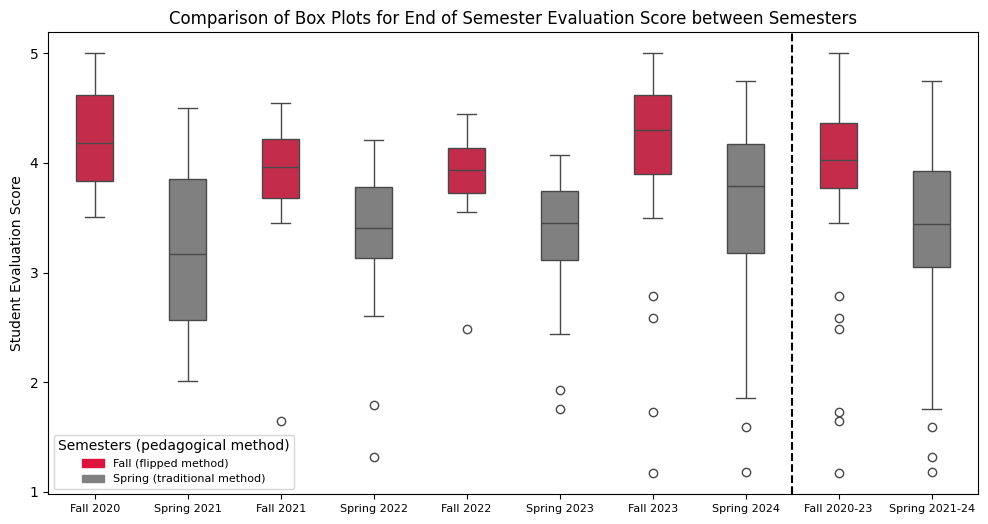

In [75]:
# Reshape the data
data = pd.DataFrame({
    'Semester': (
        ['Fall 2020'] * df['F20'].dropna().shape[0] +
        ['Spring 2021'] * df['S21'].dropna().shape[0] +
        ['Fall 2021'] * df['F21'].dropna().shape[0] +
        ['Spring 2022'] * df['S22'].dropna().shape[0] +
        ['Fall 2022'] * df['F22'].dropna().shape[0] +
        ['Spring 2023'] * df['S23'].dropna().shape[0] +
        ['Fall 2023'] * df['F23'].dropna().shape[0] +
        ['Spring 2024'] * df['S24'].dropna().shape[0] +
        ['Fall 2020-23'] * df[['F20', 'F21', 'F22', 'F23']].stack().dropna().shape[0] +
        ['Spring 2021-24'] * df[['S21', 'S22', 'S23', 'S24']].stack().dropna().shape[0]
    ),
    'Value': pd.concat([df['F20'].dropna(), df['S21'].dropna(),
                        df['F21'].dropna(), df['S22'].dropna(), 
                        df['F22'].dropna(), df['S23'].dropna(),
                        df['F23'].dropna(), df['S24'].dropna(),
                        df[['F20', 'F21', 'F22', 'F23']].stack().dropna(),
                        df[['S21', 'S22', 'S23', 'S24']].stack().dropna()
                       ])
})

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=data, x='Semester', y='Value', width=0.4, palette={
    'Fall 2020': 'crimson', 'Spring 2021': 'grey',
    'Fall 2021': 'crimson', 'Spring 2022': 'grey', 
    'Fall 2022': 'crimson', 'Spring 2023': 'grey',
    'Fall 2023': 'crimson', 'Spring 2024': 'grey',
    'Fall 2020-23': 'crimson', 'Spring 2021-24': 'grey'
})

plt.axvline(x=7.5, color='black', linestyle='--')      # add vertical dashed line after the 8th boxplot
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)   # reduce the size of x-axis tick labels

# Create custom rectangle handles
legend_elements = [
    Rectangle((0, 0), 1, 0.5, color='crimson', label='Fall (flipped method)'),
    Rectangle((0, 0), 1, 0.5, color='grey', label='Spring (traditional method)')
]

# Customize legend labels
new_labels = ['Fall (flipped method)', 'Spring (traditional method)']
plt.legend(labels=new_labels, handles=legend_elements, title='Semesters (pedagogical method)', prop={'size': 8}, loc='lower left')

# Choose the correct title
#plt.title('Comparison of Box Plots for End of Semester Performance Score between Semesters')
#plt.title('Comparison of Box Plots for Mid-Semester Performance Score between Semesters')
plt.title('Comparison of Box Plots for End of Semester Evaluation Score between Semesters')
#plt.title('Comparison of Box Plots for Mid-Semester Evaluation Score between Semesters')    

# Choose the correct label for y-axis
#plt.ylabel('Student Performance Score')
plt.ylabel('Student Evaluation Score')
# for evaluation - use these ticks for y-axis
plt.yticks([1, 2, 3, 4, 5])   
plt.xlabel('')     # no label needed for the x-axis

# Save the plot
plt.savefig('boxplots.jpeg', format='jpeg', dpi=600)
plt.show()

In [ ]:

# Load the dataset
df = pd.read_csv('Evaluation-Final.csv')

# Create merged variables
F20_23 = pd.DataFrame({'F20-23': pd.concat([df[['F20', 'F21', 'F22', 'F23']].stack()], ignore_index=True).dropna()})
S21_24 = pd.DataFrame({'S21-24': pd.concat([df[['S21', 'S22', 'S23', 'S24']].stack()], ignore_index=True).dropna()})
F20_S24 = pd.DataFrame({'F20-S21': pd.concat([df[['F20', 'S21', 'F21', 'S22', 'F22', 'S23', 'F23', 'S24']].stack()], ignore_index=True).dropna()})

max_length = max(len(F20_23), len(S21_24), len(F20_S24))
df = df.reindex(range(max_length))

# Academic year pairs
df['F20-S21'] = pd.concat([df[['F20', 'S21']].stack()], ignore_index=True)
df['F21-S22'] = pd.concat([df[['F21', 'S22']].stack()], ignore_index=True)
df['F22-S23'] = pd.concat([df[['F22', 'S23']].stack()], ignore_index=True)
df['F23-S24'] = pd.concat([df[['F23', 'S24']].stack()], ignore_index=True)
df['F20-23'] = F20_23
df['S21-24'] = S21_24

# Melt for plotting
data_melt = pd.melt(df, value_vars=['F20-S21', 'F21-S22', 'F22-S23', 'F23-S24', 'F20-23', 'S21-24'],
                    var_name='Academic_Year', value_name='Value')

# Map to readable labels
semester_map = {
    'F20-S21': 'Fall 2020 vs Spring 2021',
    'F21-S22': 'Fall 2021 vs Spring 2022',
    'F22-S23': 'Fall 2022 vs Spring 2023',
    'F23-S24': 'Fall 2023 vs Spring 2024',
    'F20-23': 'Fall 2020-23',
    'S21-24': 'Spring 2021-24'
}
data_melt['Semester'] = data_melt['Academic_Year'].map(semester_map)

# Create the plot
g = sns.catplot(data=data_melt, x='Semester', y='Value', col='Academic_Year', kind='box', col_wrap=3,
                palette='Set2')

g.set_titles("{col_name}")
g.set_axis_labels("Semester", "Value")
g.set_xticklabels(rotation=45)
g.fig.suptitle('Comparison of Fall and Spring Semesters', y=1.05)

# Save the plot
g.savefig('comparison_plot.jpeg', format='jpeg', dpi=300)


### 2. Series of two-sample t-tests for the difference in means

In [5]:
# First, test for the difference between Fall (merged) and Spring (merged) semesters

print("Two samples t-test for the difference in means between \n Fall (20,21,22,23) and Spring (21,22,23,24) pooled semesters")
t_statistic, p_value = ttest_ind(df['F20-23'].dropna(), df['S21-24'].dropna())
print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Two samples t-test for the difference in means between 
 Fall (20,21,22,23) and Spring (21,22,23,24) pooled semesters
t-statistic: 21.779
p-value: 3.4632451312756053e-85
There is a significant difference between the two groups.


In [6]:
# Next tests for the difference between Fall and Spring semesters for each academic year

# Fall 2020 vs Spring 2021
print("Two samples t-test for the difference in means between \n Fall'2020 vs Spring'2021 semesters")
t_statistic, p_value = ttest_ind(df['F20'].dropna(), df['S21'].dropna())
print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Two samples t-test for the difference in means between 
 Fall'2020 vs Spring'2021 semesters
t-statistic: 34.065
p-value: 2.4304241841753827e-90
There is a significant difference between the two groups.


In [7]:
# Fall 2021 vs Spring 2022
print("Two samples t-test for the difference in means between \n Fall'2021 vs Spring'2022 semesters")
t_statistic, p_value = ttest_ind(df['F21'].dropna(), df['S22'].dropna())
print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Two samples t-test for the difference in means between 
 Fall'2021 vs Spring'2022 semesters
t-statistic: 12.185
p-value: 1.0554278463510929e-26
There is a significant difference between the two groups.


In [8]:
# Fall 2022 vs Spring 2023
print("Two samples t-test for the difference in means between \n Fall'2022 vs Spring'2023 semesters")
t_statistic, p_value = ttest_ind(df['F22'].dropna(), df['S23'].dropna())
print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Two samples t-test for the difference in means between 
 Fall'2022 vs Spring'2023 semesters
t-statistic: 0.626
p-value: 0.5322140316460697
There is no significant difference between the two groups.


In [9]:
# Fall 2023 vs Spring 2024
print("Two samples t-test for the difference in means between \n Fall'2023 vs Spring'2024 semesters")
t_statistic, p_value = ttest_ind(df['F23'].dropna(), df['S24'].dropna())
print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("There is no significant difference between the two groups.")

Two samples t-test for the difference in means between 
 Fall'2023 vs Spring'2024 semesters
t-statistic: 19.391
p-value: 9.702510859819794e-51
There is a significant difference between the two groups.


### 3. Two-factor Analysis of Variance (ANOVA) tests

In [10]:
# Reshape the data for two-factor ANOVA
data = df
data_melt = pd.melt(data.reset_index(), id_vars=['index'], value_vars=['F20', 'F21', 'F22', 'F23', 'S21', 'S22', 'S23', 'S24'])
data_melt.columns = ['index', 'Semester_Year', 'Value']

# Create new columns for Semester and Academic Year
data_melt['Semester'] = data_melt['Semester_Year'].apply(lambda x: 'Fall' if 'F' in x else 'Spring')
data_melt['Academic_Year'] = data_melt['Semester_Year'].apply(lambda x: 'AY20-21' if x in ['F20', 'S21'] else ('AY21-22' if x in ['F21', 'S22'] else ('AY22-23' if x in ['F22', 'S23'] else 'AY23-24')))
data_melt.reset_index(drop=True, inplace=True)
data_melt.dropna()

,index,Semester_Year,Value,Semester,Academic_Year
0,0,F20,3.92,Fall,AY20-21
1,1,F20,3.90,Fall,AY20-21
2,2,F20,4.02,Fall,AY20-21
3,3,F20,4.41,Fall,AY20-21
4,4,F20,4.41,Fall,AY20-21
...,...,...,...,...,...
6583,108,S24,4.07,Spring,AY23-24
6584,109,S24,2.81,Spring,AY23-24
6585,110,S24,2.70,Spring,AY23-24
6586,111,S24,2.82,Spring,AY23-24


In [11]:
# Perform the two-factor ANOVA
model = ols('Value ~ C(Semester) + C(Academic_Year) + C(Semester):C(Academic_Year)', data=data_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Calculate η² (Effect Size)
anova_table['η²'] = anova_table['sum_sq'] / anova_table['sum_sq'].sum()

anova_table_df = pd.DataFrame(anova_table)
anova_table_df

,sum_sq,df,F,PR(>F),η²
C(Semester),127.858586,1.0,717.278788,3.428920e-117,0.339502
C(Academic_Year),36.700886,3.0,68.629903,4.830562e-40,0.097452
C(Semester):C(Academic_Year),48.586851,3.0,90.856413,1.758959e-51,0.129012
Residual,163.459906,917.0,NaN,NaN,0.434034


C:\Users\gani.nurmukhametov\AppData\Local\anaconda3\envs\islp\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\gani.nurmukhametov\AppData\Local\anaconda3\envs\islp\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


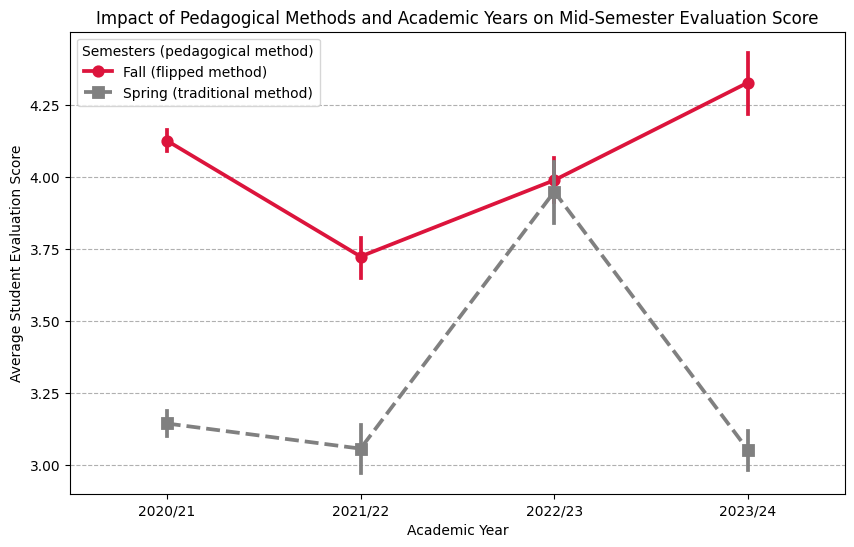

In [12]:
# Create the interaction plot
plt.figure(figsize=(10, 6))
plot = sns.pointplot(data=data_melt, x='Academic_Year', y='Value', hue='Semester',
                     markers=['o', 's'], linestyles=['-', '--'],
                     palette={'Fall': 'crimson', 'Spring': 'grey'})

# Choose the correct title
#plt.title('Impact of Pedagogical Methods and Academic Years on End of Semester Performance Score')
#plt.title('Impact of Pedagogical Methods and Academic Years on Mid-Semester Performance Score')
#plt.title('Impact of Pedagogical Methods and Academic Years on End of Semester Evaluation Score')
plt.title('Impact of Pedagogical Methods and Academic Years on Mid-Semester Evaluation Score')

# Choose the correct label for y-axis
#plt.ylabel('Average Student Performance Score')
plt.ylabel('Average Student Evaluation Score')

plt.xlabel('Academic Year')   # the label for x-axis won't change

# Customize legend labels
new_labels = ['Fall (flipped method)', 'Spring (traditional method)']
handles, _ = plot.get_legend_handles_labels()
plt.legend(handles=handles, labels=new_labels, title='Semesters (pedagogical method)', loc='upper left')

# Remove vertical gridlines and add horizontal gridlines at specific y-values
plt.grid(axis='y', which='both', linestyle='--')  # Horizontal gridlines
plt.grid(axis='x', which='both', linestyle='')    # No vertical gridlines
plt.grid(True)

plt.yticks([3.0, 3.25, 3.5, 3.75, 4, 4.25])            # Set y-ticks to match desired gridlines (for Eval: Mid)
#plt.yticks([3.25, 3.5, 3.75, 4, 4.25])                 # Set y-ticks to match desired gridlines (for Eval: Final)
#plt.yticks([65, 70, 75, 80])                           # Set y-ticks to match desired gridlines (for Perf, both Mid and Final)
plt.xticks(ticks=range(4), labels=['2020/21', '2021/22', '2022/23', '2023/24'])    # rename x-axis tick labels

plt.savefig('plot.jpeg', format='jpeg', dpi=600)
plt.show()